# Remoção de um dado em modelos de Regressão linear

Vamos criar um conjunto de dados com outliers e ver como a remoção deles afeta o modelo de regressão linear.

In [2]:
# conjunto de dados de treinamento linear com pequeno ruido gaussiano

import numpy as np
import matplotlib.pyplot as plt

# numero de amostras
N = 20

# parametros da reta
a = 2
b = 3

# ruido gaussiano
mu = 0
sigma = 0.5

# gerando os dados
x = np.random.rand(N) * 10
y = a*x + b + np.random.normal(mu, sigma, N)

# Adicionando um outlier
x_with_outlier = np.append(x, 10)
y_with_outlier = np.append(y, 0)

Text(0, 0.5, 'y')

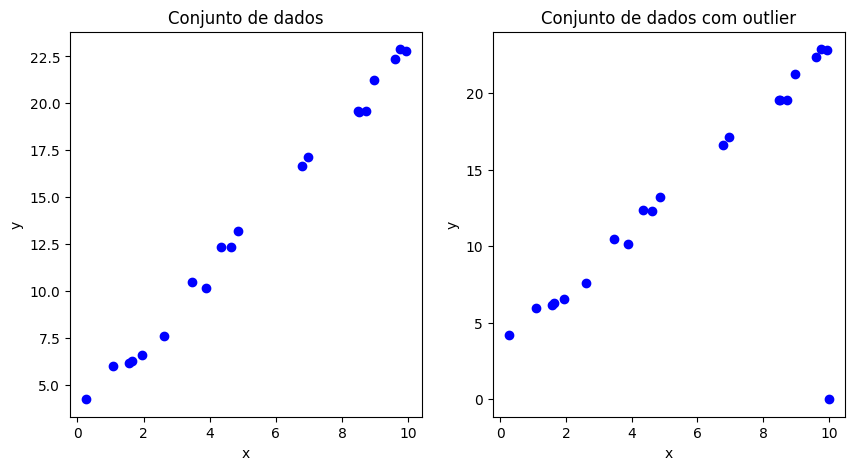

In [3]:
# plotando os dados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x, y, color='blue')
ax[0].set_title('Conjunto de dados')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(x_with_outlier, y_with_outlier, color='blue')
ax[1].set_title('Conjunto de dados com outlier')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')



### Treinamento os modelos

Assim como no paper, nossa ideia é treinar o modelo com o outlier e depois remover ele sem re-treinar o modelo. Daí, vamos comparar o modelo treinado com e sem o outlier.

In [4]:
def linear_model(x, y):
    x = np.array(x)
    y = np.array(y)
    x = np.c_[np.ones(x.shape[0]), x]
    beta = np.linalg.inv(x.T @ x) @ x.T @ y
    return beta

In [5]:
# Modelo linear sem outlier
beta = linear_model(x, y)

# Modelo linear com outlier
beta_with_outlier = linear_model(x_with_outlier, y_with_outlier)

print ('Coeficientes do modelo sem outlier:', beta)
print ('Coeficientes do modelo com outlier:', beta_with_outlier)

Coeficientes do modelo sem outlier: [3.23930081 1.96661671]
Coeficientes do modelo com outlier: [4.64436188 1.5223909 ]


Text(0, 0.5, 'y')

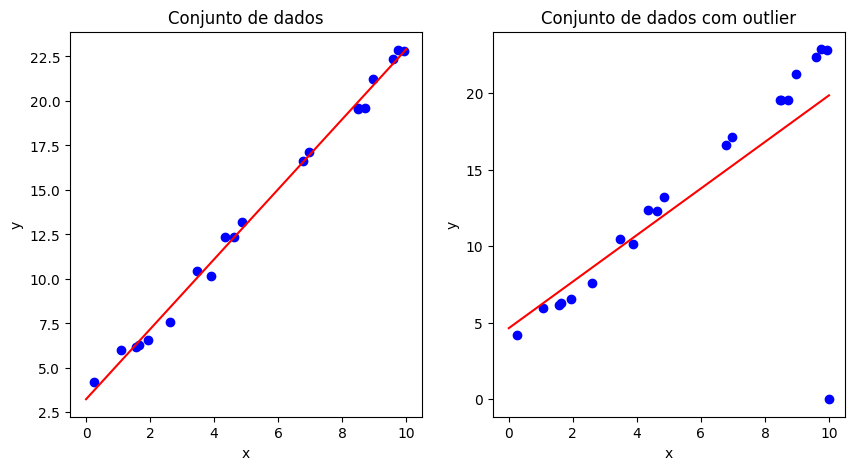

In [6]:
# plotando a reta

x_plot = np.linspace(0, 10, 100)
y_plot = beta[0] + beta[1]*x_plot
y_plot_with_outlier = beta_with_outlier[0] + beta_with_outlier[1]*x_plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x, y, color='blue')
ax[0].plot(x_plot, y_plot, color='red')
ax[0].set_title('Conjunto de dados')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(x_with_outlier, y_with_outlier, color='blue')
ax[1].plot(x_plot, y_plot_with_outlier, color='red')
ax[1].set_title('Conjunto de dados com outlier')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')


## Removendo o ponto

Com o modelo treinado, desejamos remover o outlier e, sem re-treinar o modelo, ver se ele se aproxima do modelo treinado sem o outlier.

Do paper:

> Supomos, sem perda de generalidade, que visamos remover a última amostra de treinamento, $\left(\mathbf{x}_{n}, y_{n}\right)$. Especificamente, definimos um mecanismo de remoção eficiente que minimiza aproximadamente $L\left(\mathbf{w} ; \mathcal{D}^{\prime}\right)$ com $\mathcal{D}^{\prime}=\mathcal{D} \backslash\left(\mathbf{x}_{n}, y_{n}\right)$. Primeiramente, denotamos o gradiente da perda na amostra $\left(\mathbf{x}_{n}, y_{n}\right)$ por $\Delta=\lambda \mathbf{w}^{*}+\nabla \ell\left(\left(\mathbf{w}^{*}\right)^{\top} \mathbf{x}_{n}, y_{n}\right)$ e a Hessiana de $L\left(\cdot ; \mathcal{D}^{\prime}\right)$ em $\mathbf{w}^{*}$ por $H_{\mathbf{w}^{*}}=\nabla^{2} L\left(\mathbf{w}^{*} ; \mathcal{D}^{\prime}\right)$. Consideramos o mecanismo de atualização de Newton $M$:
> $$
> \mathbf{w}^{-}=M\left(\mathbf{w}^{*}, \mathcal{D},\left(\mathbf{x}_{n}, y_{n}\right)\right):=\mathbf{w}^{*}+H_{\mathbf{w}^{*}}^{-1} \Delta
> $$
> **que é uma atualização de Newton de um passo aplicada à influência do gradiente do ponto removido $\left(\mathbf{x}_{n}, y_{n}\right)$**. A atualização $H_{\mathbf{w}^{*}}^{-1} \Delta$ também é conhecida como a função de influência do ponto de treinamento $\left(\mathbf{x}_{n}, y_{n}\right)$ no vetor de parâmetros $\mathbf{w}^{}$ (Cook and Weisberg, 1982; Koh and Liang, 2017).


In [7]:
x_without_outlier = x_with_outlier[:-1]
y_without_outlier = y_with_outlier[:-1]

In [8]:
def gradient_loss(beta, x_i, y_i):
    x_i = np.append(1, x_i)

    # Calcula o gradiente da perda para a amostra (x_i, y_i) com base nos coeficientes beta
    grad_loss = - 2 * (y_i - beta @ x_i) * x_i
    return grad_loss

def Hessian_loss(beta, X, Y):
    X = np.column_stack([np.ones(len(X)), X])
    
    # Calcula a Hessiana da perda com base nos coeficientes beta e no conjunto de dados X e Y
    Hessian = 2 * X.T @ X
    return Hessian

In [9]:
beta_with_outlier

array([4.64436188, 1.5223909 ])

In [10]:
w_star = np.array(beta_with_outlier)

# Coloca mais uma dimensão no vetor w_star
w_star = w_star[:, np.newaxis].T

lambda_val = 0.1
Delta = lambda_val * w_star + np.array([gradient_loss(beta_with_outlier, x_with_outlier[-1], y_with_outlier[-1])])

H_w_star_inv = np.linalg.inv(Hessian_loss(beta_with_outlier, x_with_outlier[:-1], y_with_outlier[:-1]))

w_minus = w_star + (H_w_star_inv @ Delta.T).T

In [11]:
print ('Coeficientes do modelo treinando sem o outlier:', beta)
print ('Coeficientes do modelo treinando com o outlier:', beta_with_outlier)
print ('Coeficientes do modelo treinando com o outlier e depois removendo:', w_minus)

Coeficientes do modelo treinando sem o outlier: [3.23930081 1.96661671]
Coeficientes do modelo treinando com o outlier: [4.64436188 1.5223909 ]
Coeficientes do modelo treinando com o outlier e depois removendo: [[3.28181257 1.96089351]]


Podemos ver que ao remover o dado outlier, o modelo se aproxima do modelo treinado sem o outlier.

Text(0, 0.5, 'y')

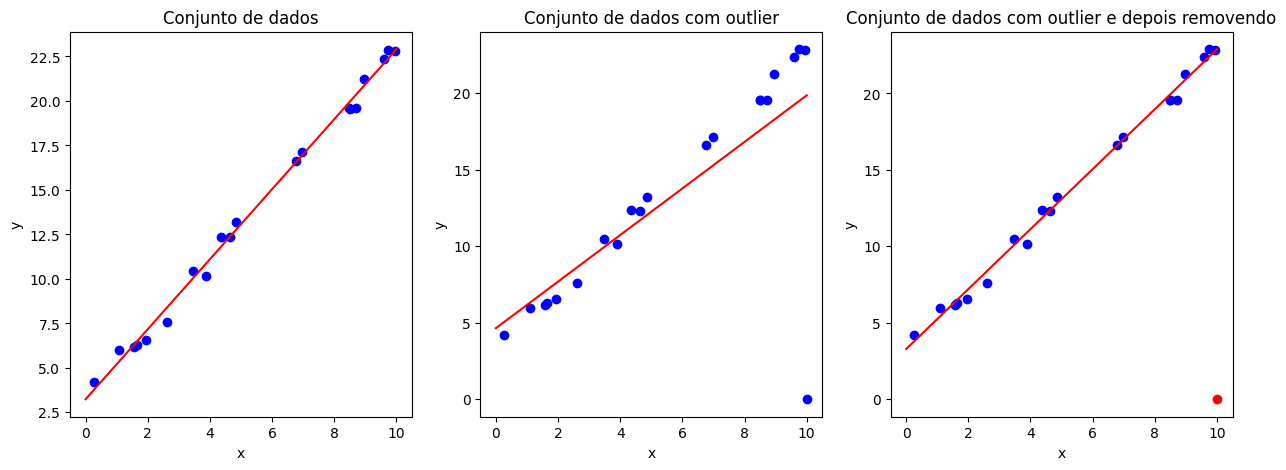

In [12]:
# plotando a reta

x_plot = np.linspace(0, 10, 100)
y_plot = beta[0] + beta[1]*x_plot
y_plot_with_outlier = beta_with_outlier[0] + beta_with_outlier[1]*x_plot
y_plot_minus = w_minus[0, 0] + w_minus[0, 1]*x_plot

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(x, y, color='blue')
ax[0].plot(x_plot, y_plot, color='red')
ax[0].set_title('Conjunto de dados')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(x_with_outlier, y_with_outlier, color='blue')
ax[1].plot(x_plot, y_plot_with_outlier, color='red')
ax[1].set_title('Conjunto de dados com outlier')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')


ax[2].scatter(x_with_outlier[:-1], y_with_outlier[: -1], color='blue')
ax[2].scatter(x_with_outlier[-1], y_with_outlier[-1], color='red')
ax[2].plot(x_plot, y_plot_minus, color='red')
ax[2].set_title('Conjunto de dados com outlier e depois removendo')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')



# Regressão Logística

Vamos fazer o mesmo experimento com a Regressão Logística.

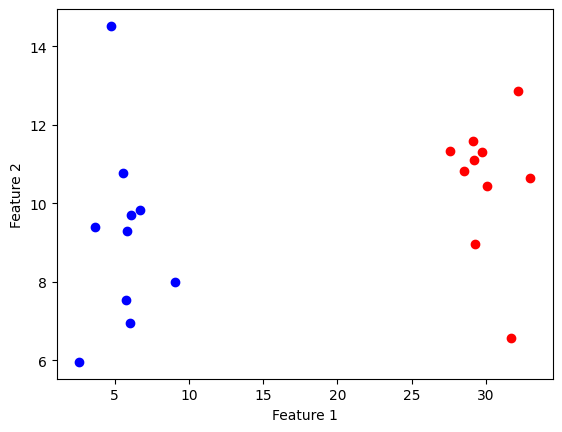

In [156]:
# Cria um dataset linearmente separável com duas classes e duas features

N = 10

# Pontos da classe 1: gaussianos com média 10 e desvio padrão 5
v1 = np.random.normal(5, 2, N)
v2 = np.random.normal(10, 2, N)

# Pontos da classe 2: gaussianos com média 20 e desvio padrão 5
w1 = np.random.normal(30, 2, N)
w2 = np.random.normal(10, 2, N)

# Cria o conjunto de dados
# X -> primeira feature é v1 e w1 e a segunda é v2 e w2
# Y -> 0 para a classe 1 e 1 para a classe 2
X = np.column_stack([np.append(v1, w1), np.append(v2, w2)])
Y = np.append(np.zeros(N), np.ones(N))

# Plotando o conjunto de dados
plt.scatter(X[:N, 0], X[:N, 1], color='blue')
plt.scatter(X[N:, 0], X[N:, 1], color='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Vamos adicionar um outlier

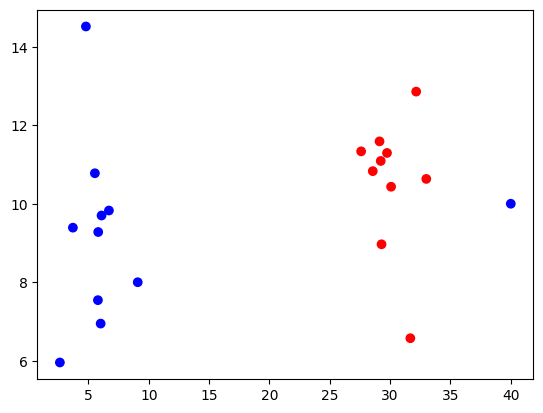

In [157]:
# adiciona um ponto em X
X_with_outlier = np.vstack([X, [40, 10]])
Y_with_outlier = np.append(Y, 0)

# plotando o conjunto de dados
plt.scatter(X_with_outlier[:, 0], X_with_outlier[:, 1], color=['blue' if y == -0 else 'red' for y in Y_with_outlier])

### Criando um modelo de Regressão Logística

In [170]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


def train_logistic_regression(X, Y, max_iter=40):
    # regressão logística usando o método de Newton-Raphson
    # X -> matriz de características
    # Y -> vetor de rótulos

    # adiciona uma coluna de 1s em X
    X = np.column_stack([np.ones(X.shape[0]), X])

    # inicializa os coeficientes
    beta = np.zeros(X.shape[1])
    loss = []

    for _ in range(max_iter):
        # print(beta)
        # calcula o gradiente da função de perda
        grad = (sigmoid(X @ beta) - Y) @ X

        # calcula a Hessiana da função de perda
        H = X.T @ np.diag(sigmoid(X @ beta) * (1 - sigmoid(X @ beta))) @ X

        # atualiza os coeficientes
        beta -=  np.linalg.inv(H) @ grad

        # calcula a perda
        loss.append(np.sum(-Y * np.log(sigmoid(X @ beta) + 1e-10) - (1 - Y) * np.log(1 - sigmoid(X @ beta) + 1e-10)))
        print(loss[-1])
    
    return beta
    
def predict_logistic_regression(X, beta):
    # prediz a classe de cada amostra em X
    return np.round(sigmoid(X @ beta))

    
model_without_outlier = train_logistic_regression(X, Y)
model_with_outlier = train_logistic_regression(X_with_outlier, Y_with_outlier)


print('Coeficientes do modelo sem outlier:', model_without_outlier)
print('Coeficientes do modelo com outlier:', model_with_outlier)
    

2.694596658438111
0.9308681848784017
0.3403538460679539
0.12656055906138952
0.04730343600088053
0.017696133121293613
0.006615307410621279
0.0024697036339005433
0.0009206349865409427
0.0003426773029195126
0.00012737410006281963
4.7285555983568584e-05
1.7533796681730748e-05
6.494536428725578e-06
2.402743733815078e-06
8.874736818279935e-07
3.2678783682164304e-07
1.1946532302722554e-07
4.28511582908039e-08
1.4554137037196089e-08
4.107651223131319e-09
2.5266688791026034e-10
-1.1693990219573216e-09
-1.6938204171776166e-09
-1.8871606498811516e-09
-1.95842275720167e-09
-1.984682862400699e-09
-1.9943573458363422e-09
-1.997921383789641e-09
-1.9992343335384317e-09
-1.99971794668791e-09
-1.999896026461043e-09
-1.9999619737086987e-09
-1.9999861765706334e-09
-1.9999948363102247e-09
-1.999998166979298e-09
-1.9999992772023228e-09
-1.9999999433361376e-09
-1.9999999433361376e-09
-2.0000001653807425e-09
6.558584806610222
5.812932922898755
5.717845730131695
5.713380345494709
5.713364104282671
5.7133641040

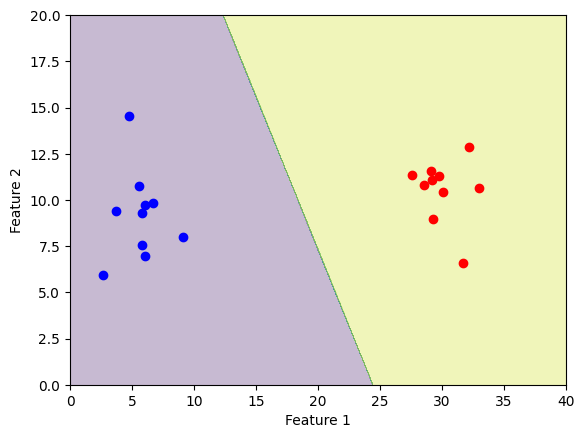

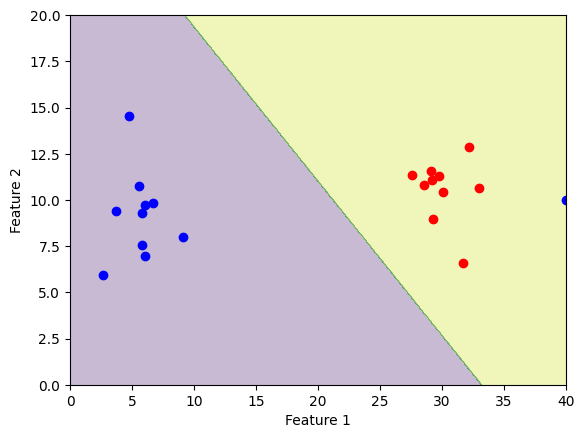

In [171]:
# Plota a fronteira de decisão
x1 = np.linspace(0, 40, 1000)
x2 = np.linspace(0, 20, 1000)
x1, x2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([np.ones(x1.ravel().shape), x1.ravel(), x2.ravel()])
# Y_grid = model_without_outlier.predict(X_grid)
Y_grid = predict_logistic_regression(X_grid, model_without_outlier)
Y_grid = Y_grid.reshape(x1.shape)
 
plt.contourf(x1, x2, Y_grid, alpha=0.3)
plt.scatter(X[:N, 0], X[:N, 1], color='blue')
plt.scatter(X[N:, 0], X[N:, 1], color='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plota a fronteira de decisão
x1 = np.linspace(0, 40, 1000)
x2 = np.linspace(0, 20, 1000)
x1, x2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([np.ones(x1.ravel().shape), x1.ravel(), x2.ravel()])
# Y_grid = model_with_outlier.predict(X_grid)
Y_grid = predict_logistic_regression(X_grid, model_with_outlier)
Y_grid = Y_grid.reshape(x1.shape)

plt.contourf(x1, x2, Y_grid, alpha=0.3)
plt.scatter(X_with_outlier[:N, 0], X_with_outlier[:N, 1], color='blue')
plt.scatter(X_with_outlier[N:-1, 0], X_with_outlier[N:-1, 1], color='red')
plt.scatter(X_with_outlier[-1, 0], X_with_outlier[-1, 1], color='blue')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Removendo o outlier e comparando os modelos

$$\mathbf{w}^{-}=M\left(\mathbf{w}^{*}, \mathcal{D},\left(\mathbf{x}_{n}, y_{n}\right)\right):=\mathbf{w}^{*}+H_{\mathbf{w}^{*}}^{-1} \Delta \tag{3}$$

$$
\begin{aligned}
\nabla \ell\left(\mathbf{w}^{\top} \mathbf{x}_{i}, y_{i}\right) & =\left(\sigma\left(y_{i} \mathbf{w}^{\top} \mathbf{x}_{i}\right)-1\right) y_{i} \mathbf{x}_{i} \\
\nabla^{2} \ell\left(\mathbf{w}^{\top} \mathbf{x}_{i}, y_{i}\right) & =\sigma\left(y_{i} \mathbf{w}^{\top} \mathbf{x}_{i}\right)\left(1-\sigma\left(y_{i} \mathbf{w}^{\top} \mathbf{x}_{i}\right)\right) \mathbf{x}_{i} \mathbf{x}_{i}^{\top}
\end{aligned}
$$

Coeficientes do modelo treinando sem o outlier: [-90.22756619   3.6948497    2.23098509]
Coeficientes do modelo treinando com o outlier: [-6.61196575  0.19921646  0.23853385]
Coeficientes do modelo treinando com o outlier e depois removendo: [-23.06269705   0.40058413   1.39973695]


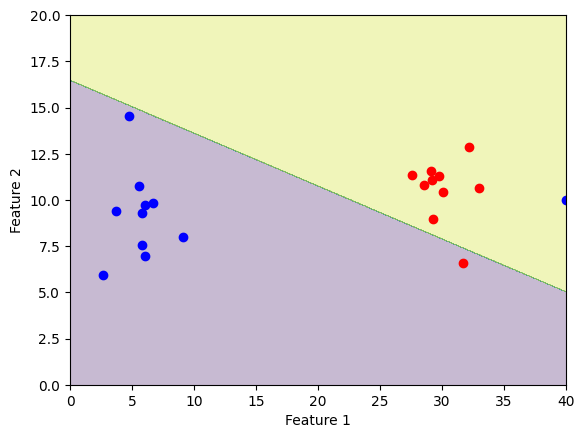

In [207]:

# grad = (sigmoid(X @ beta) - Y) @ X

# # calcula a Hessiana da função de perda
# H = X.T @ np.diag(sigmoid(X @ beta) * (1 - sigmoid(X @ beta))) @ X

def gradient_loss(beta, x_i, y_i):
    # adiciona um 1 na primeira posição de x_i
    x_i = np.append(1, x_i)

    # grad for -1 and 1
    # grad_loss = (1 / (1 + np.exp(-y_i * beta @ x_i)) - 1) * y_i * x_i
    # return grad_loss

    # Calcula o gradiente da perda para a amostra (x_i, y_i) com base nos coeficientes beta
    grad_loss = - (y_i - 1 / (1 + np.exp(-beta @ x_i))) * x_i
    return grad_loss



def Hessian_loss(beta, X, Y):
    X = np.column_stack([np.ones(len(X)), X])
    #\nabla^{2} \ell\left(\mathbf{w}^{\top} \mathbf{x}_{i}, y_{i}\right) & =\sigma\left(y_{i} \mathbf{w}^{\top} \mathbf{x}_{i}\right)\left(1-\sigma\left(y_{i} \mathbf{w}^{\top} \mathbf{x}_{i}\right)\right) \mathbf{x}_{i} \mathbf{x}_{i}^{\top}

    # Calcula a Hessiana da perda com base nos coeficientes beta e no conjunto de dados X e Y
    # Hessian = np.zeros((X.shape[1], X.shape[1]))
    # for i in range(X.shape[0]):
    #     x_i = X[i]
    #     y_i = Y[i]
    #     sigma = 1 / (1 + np.exp(y_i * beta @ x_i))
    #     Hessian += sigma * (1 - sigma) * np.outer(x_i, x_i)
    # return Hessian

    Hessian = X.T @ np.diag(sigmoid(X @ beta) * (1 - sigmoid(X @ beta))) @ X
    return Hessian

def predict_logistic_regression(X, beta):
    # prediz a classe de cada amostra em X
    return np.round(sigmoid(X @ beta.T))

w_star = np.array(model_with_outlier)

lambda_val = 0.1
Delta = np.array([gradient_loss(w_star, X_with_outlier[-1], Y_with_outlier[-1])]) + lambda_val * w_star

H_w_star_inv = np.linalg.inv(Hessian_loss(w_star, X_with_outlier[:-1], Y_with_outlier[:-1]))
w_minus = np.squeeze(w_star + (Delta @ H_w_star_inv))


print ('Coeficientes do modelo treinando sem o outlier:', model_without_outlier)
print ('Coeficientes do modelo treinando com o outlier:', model_with_outlier)
print ('Coeficientes do modelo treinando com o outlier e depois removendo:', w_minus)

# Plota a fronteira de decisão
x1 = np.linspace(0, 40, 1000)
x2 = np.linspace(0, 20, 1000)
x1, x2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([np.ones(x1.ravel().shape), x1.ravel(), x2.ravel()])
# Y_grid = model_with_outlier.predict(X_grid)
Y_grid = predict_logistic_regression(X_grid, w_minus)
Y_grid = Y_grid.reshape(x1.shape)

plt.contourf(x1, x2, Y_grid, alpha=0.3)
plt.scatter(X_with_outlier[:N, 0], X_with_outlier[:N, 1], color='blue')
plt.scatter(X_with_outlier[N:-1, 0], X_with_outlier[N:-1, 1], color='red')
plt.scatter(X_with_outlier[-1, 0], X_with_outlier[-1, 1], color='blue')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

